# 1 Iterative SENSE
## Assignment
#### Consider the fully sampled image m.mat and the coil sensitivity maps C.mat from an 8-channel brain coil ($N_{c} = 8$). Apply the coil sensitivity information to the image data creating the coil images $m_{c}$ obtained by each of the coils.

#### Load the necessary modules and package.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

#### Define the transformation functions between k-space domain and image domain.

In [2]:
def image2kspace(x):
    if isinstance(x, np.ndarray):
        x = np.fft.ifftshift(x, axes=(-2, -1))
        x = np.fft.fft2(x)
        x = np.fft.fftshift(x, axes=(-2, -1))
        return x
    else:
        raise RuntimeError("Unsupported type.")


def kspace2image(x):
    if isinstance(x, np.ndarray):
        x = np.fft.ifftshift(x, axes=(-2, -1))
        x = np.fft.ifft2(x)
        x = np.fft.fftshift(x, axes=(-2, -1))
        return x
    else:
        raise RuntimeError("Unsupported type.")

## Load the image and coil arrays.

In [3]:
image = np.array(sio.loadmat('./M.mat')['M'])
coils = np.array(sio.loadmat('./C.mat')['C']).transpose((2, 0, 1))
print(f'The shape of image is: {image.shape}, the dtype of image is: {image.dtype}')
print(f'The shape of coil is: {coils.shape}, the dtype of coil is: {coils.dtype}')

The shape of image is: (256, 256), the dtype of image is: float64
The shape of coil is: (8, 256, 256), the dtype of coil is: complex128


#### (a) Determine and depict $m$ (the 2D fully sampled provided image), $C_{i}, i = 1,2,...,N_{c}$ and $m_{i}, i = 1,2,...,N_{c}$. Employ the root-sum-of-square approach and the weighted coil sensitivity approach to combine the data from the individual coils. Depict and compare the combined images with respect to the original fully sample image $m$.

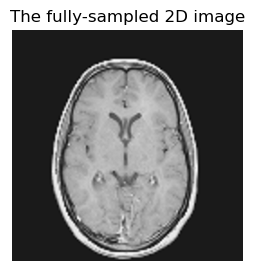

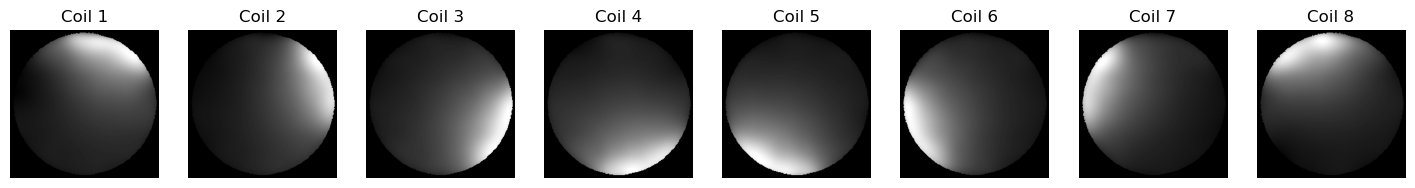

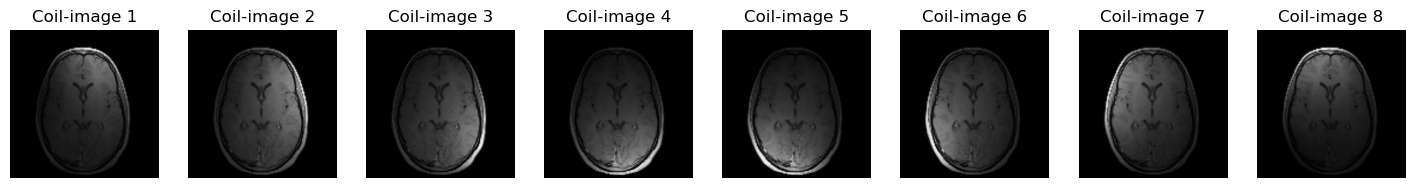

In [4]:
# depict the fully sampled image, the coil sensitivity maps and the coil images
plt.figure(figsize=(3, 3))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('The fully-sampled 2D image')

plt.figure(figsize=(18, 6))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(np.abs(coils[i]), cmap='gray')
    plt.axis('off')
    plt.title(f'Coil {i + 1}')

coil_images = []
plt.figure(figsize=(18, 6))
for i in range(coils.shape[0]):
    coil_images.append(image * coils[i])
    plt.subplot(1, 8, i + 1)
    plt.imshow(np.abs(coil_images[-1]), cmap='gray')
    plt.axis('off')
    plt.title(f'Coil-image {i + 1}')

Text(0.5, 1.0, 'Weighted coil sensitivity image')

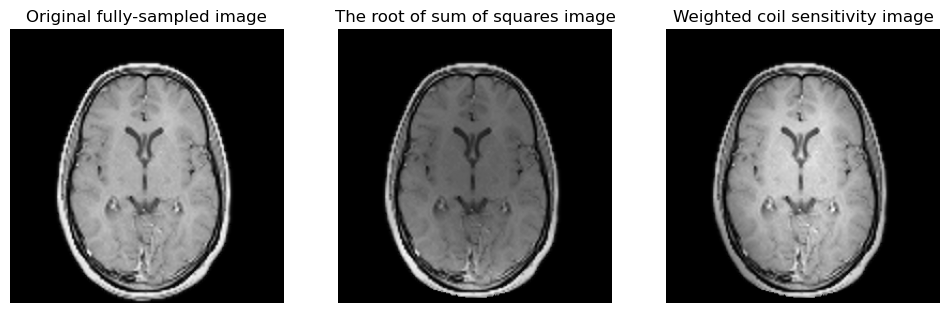

In [5]:
rss= np.sqrt(np.sum(np.abs(coil_images) ** 2, axis=0))

coe = [np.abs(coils[i]) **2  for i in range(coils.shape[0])]
coe = np.sqrt(np.sum(coe, axis=0))
co_sens = np.sum(coil_images, axis=0) / (coe+1e-6)


plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(np.abs(image), cmap='gray')
plt.axis('off')
plt.title('Original fully-sampled image')
plt.subplot(1, 3, 2)
plt.imshow(rss, cmap='gray')
plt.axis('off')
plt.title('The root of sum of squares image')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(co_sens), cmap='gray')
plt.axis('off')
plt.title('Weighted coil sensitivity image')

#### (b) Generate 2 uniform undersampling patterns with acceleration factors of 3 and 7 ($U_{3}$ and $U_{7}$) and 2 random undersampling patterns ($U_{R3}$ and $U_{R7}$). Each sampling pattern must be a matrix with $1s$ in the sampled positions and $0s$ in the remaining entries. Obtain the corresponding **point spread functions (PSFs)** and comment about the expected aliasing generated by these undersampling patterns.

In [6]:
U3, U7, UR3, UR7 = np.zeros(image.shape), np.zeros(image.shape), np.zeros(image.shape), np.zeros(image.shape)
U3[::3] = 1 
U7[::7] = 1
ind3 = np.random.choice(range(256), size=256//3, replace=True)
ind7 = np.random.choice(range(256), size=256//7, replace=True)
UR3[ind3] = 1
UR7[ind7] = 1


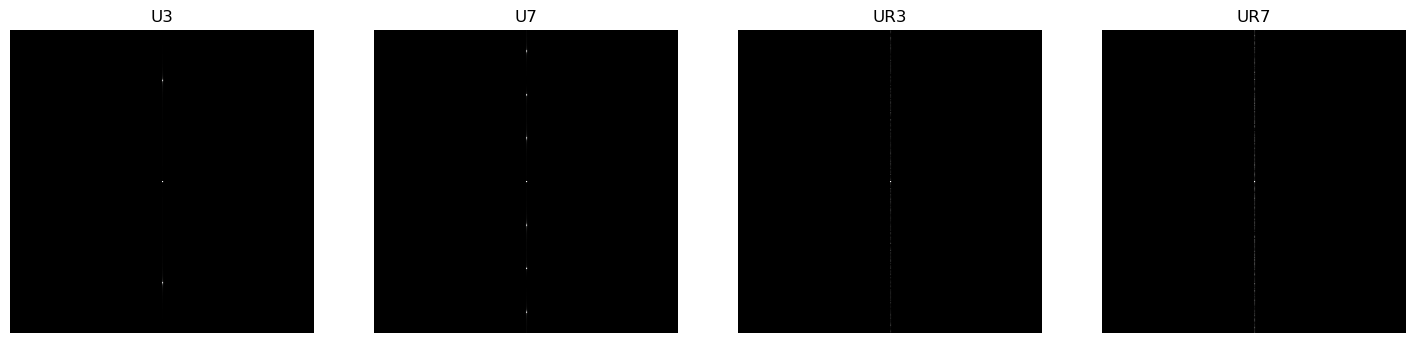

In [7]:
pattern = ['U3', 'U7', 'UR3', 'UR7']
mask_list = [U3, U7, UR3, UR7]
plt.figure(figsize=(18, 6))
for i in range(len(mask_list)):
    plt.subplot(1, 4, i+1)
    plt.imshow(np.abs(kspace2image(mask_list[i])), cmap='gray')
    plt.axis('off')
    plt.title(pattern[i])

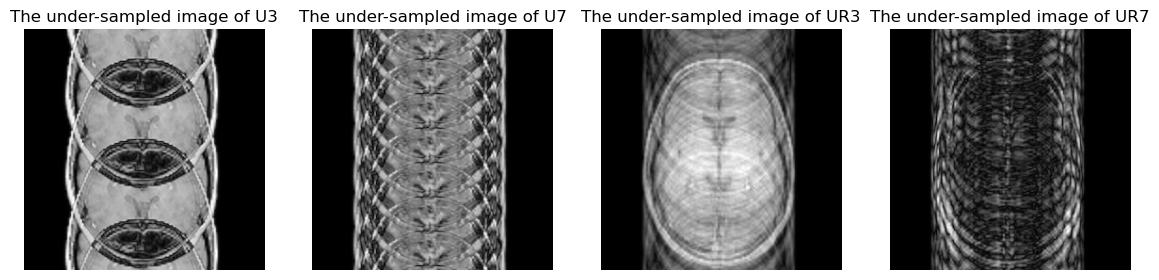

In [8]:
kspace = image2kspace(image)
under_sampled_list = [kspace*mask for mask in mask_list]
plt.figure(figsize=(18, 6))
for i in range(4):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.abs(kspace2image(under_sampled_list[i])), cmap='gray')
    plt.axis('off')
    plt.title(f'The under-sampled image of {pattern[i]}')

#### (c) Obtain the aliased images for each coil as a result of undersampling with the generated patterns. For this you should use:$$b_{i} = F^{-1}UFC_{i}m$$where $U$ is the corresponding undersampling pattern, $F$ is the Fourier transform and $b_{i}$ are the aliased images for each coil $i = 1,...,N_{c}$. Depict and compare the aliased images for the different undersampling factors and patterns.


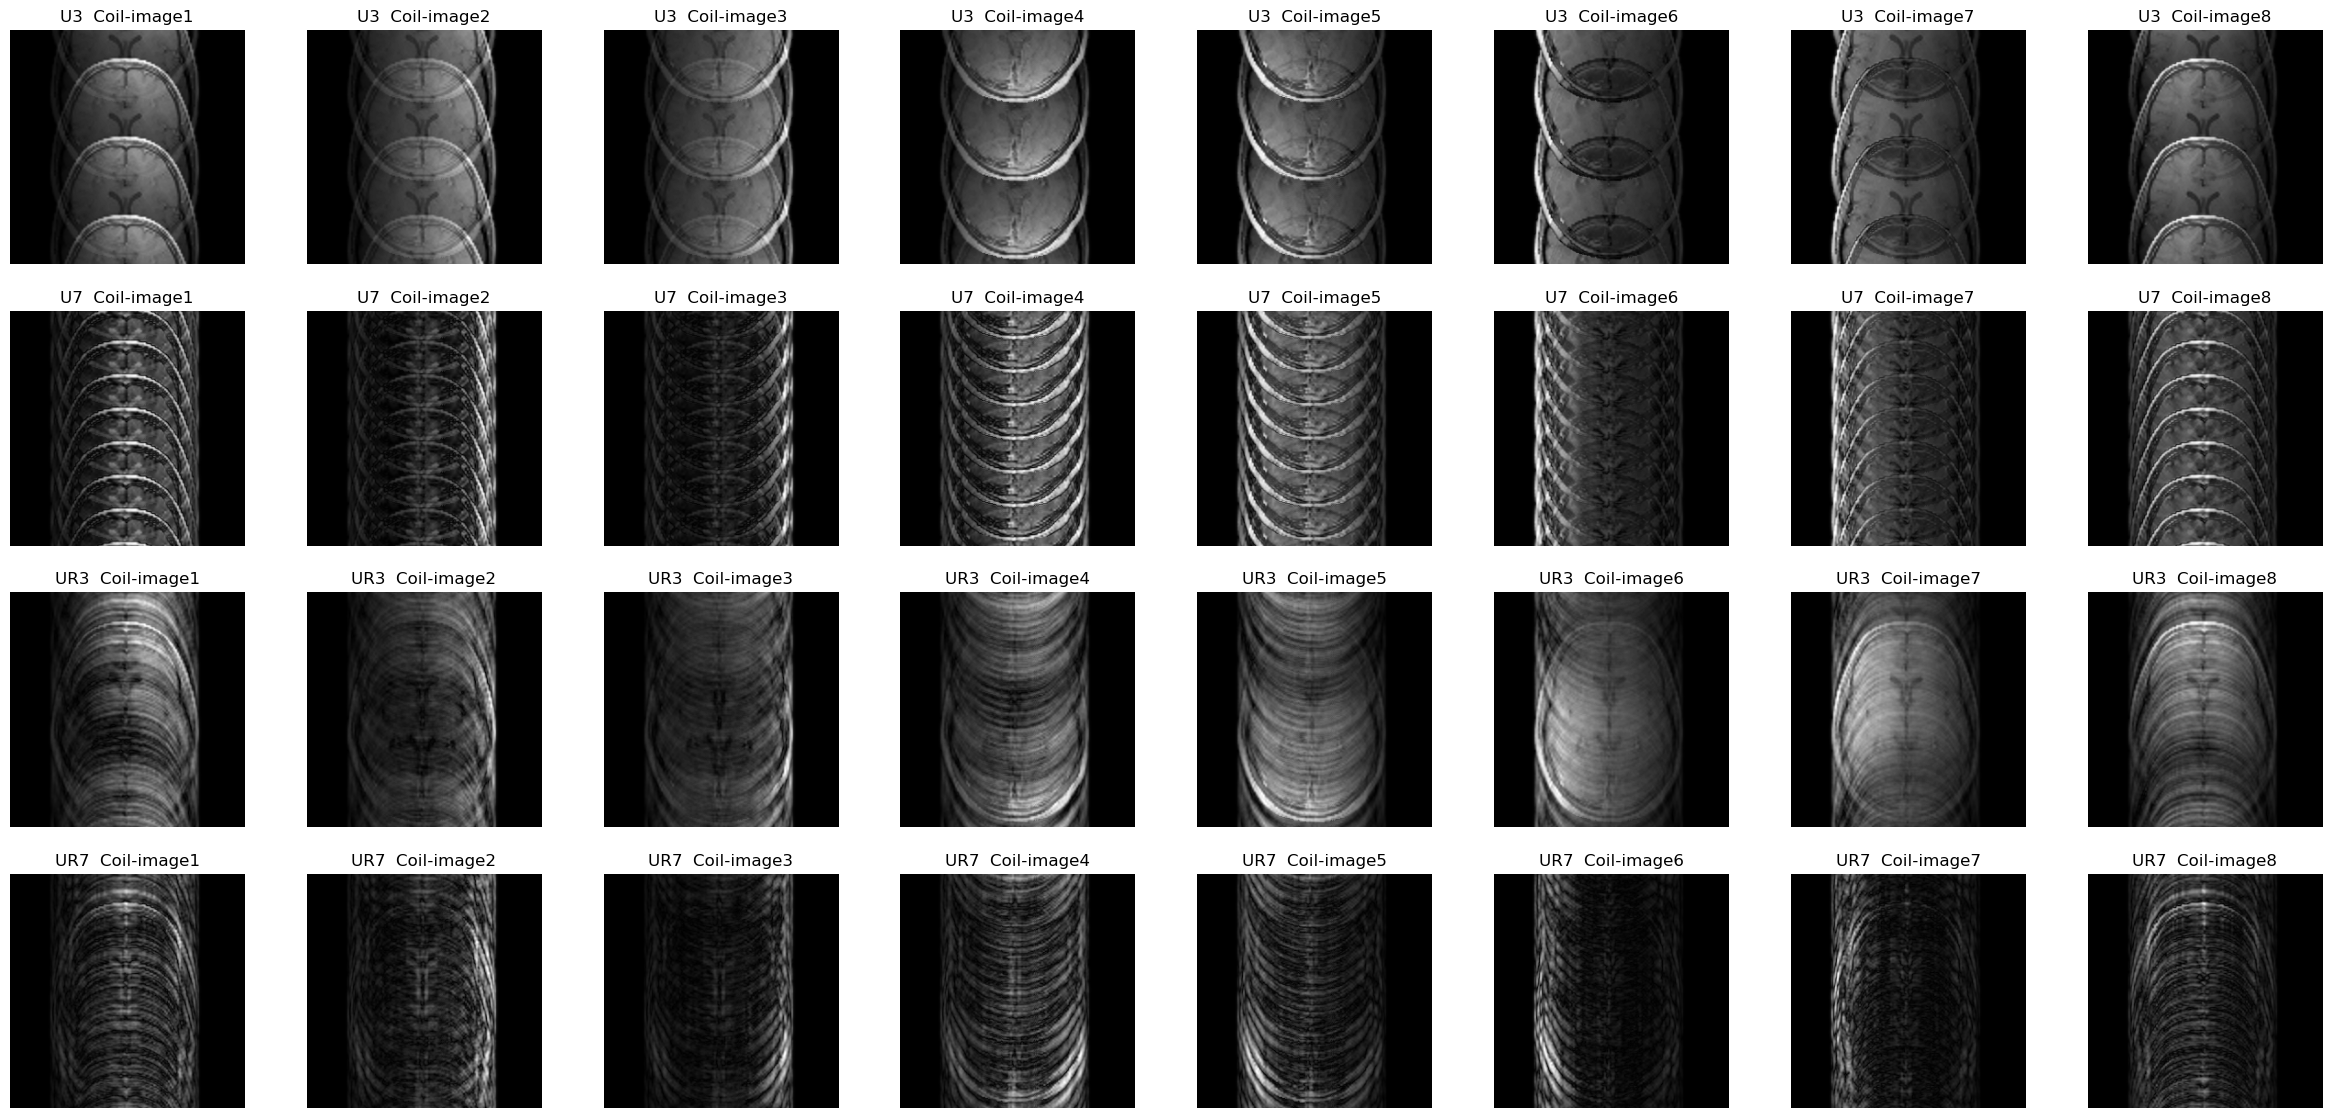

In [9]:
# 遍历每个mask
i=0
plt.figure(figsize=(30, 14))
for mask in mask_list:
    for coil_image in coil_images:
        masked_coil_image = image2kspace(coil_image) * mask
        plt.subplot(4, 8, i+1)
        plt.imshow(np.abs(kspace2image(masked_coil_image)), cmap='gray')
        plt.axis('off')
        plt.title(f'{pattern[i//8]}  Coil-image{i%8 + 1}')
        i += 1

##### (d) The SENSE under-sampled reconstruction can be written as a linear problem:$$Em=B$$where $m$ is the image to be reconstructed and the encoding matrix $E = UFC$ corresponds to the forward sampling operator, with $U$ the undersampling operator, $F$ the Fourier transform operator, $C$ the coil sensitivity maps and $B$ the undersampled k-space data. Iterative SENSE reconstruction is obtained by solving the linear problem $Em = B$ as a least square minimization $\mathop{\min}\limits_{m}||Em-B||_{2}^{2}$. Implement the Gradient Descent method to solve the above problem. To do this, you can use the forward $E$ and conjugate transpose $E^{H}$ SENSE encoding operators you implemented in MRI Recon Lab. Show and compare your results for the undersampling patterns generated in part (b). What can you conclude from them? How many iterations are needed to reconstruct acquisitions with the different sampling patterns?

In [10]:
def E(mask, F, C):
    """
    Define the forward operator E
    
    Parameters:
    mask: the mask to undersampling the k-space data (256, 256)
    F: the Fourier transform operator
    C: the coil sensitivity maps with the shape of (coil_num, height, width) (8, 256, 256)
    """
    coe = np.sqrt(np.sum(C.conj() * C, axis=0))
    eps = 1e-6
    def E_op(image):
        return mask * F(C/(coe +eps) * image)  # 返回是k空间降采样测量值 8通道 复数
    return E_op

def E_H(mask, F_H, C):
    """
    Define the conjugate transpose of the forward operator E
    
    Parameters:
    mask: the mask used in the forward operator E
    F_H: the inverse Fourier transform operator
    C: the coil sensitivity maps with the shape of (coil_num, height, width) (8, 256, 256)
    """
    coe = np.sqrt(np.sum(C.conj() * C, axis=0))
    def E_H_op(kspace): 
        return np.sum(C.conj() * F_H(mask * kspace), axis=0) / (coe + 1e-6) 
    return E_H_op    

def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

To solve this question, it's necessary to introduce some math definitions. 

In [11]:
def gradient_descent(mask, B, m_init, coil, fs, max_iter=20):
    mse = []
    m = m_init.copy()
    #while np.linalg.norm(gradient)>1e-6:
    eps = 1e-6
    coe = [np.abs(coils[i]) **2  for i in range(coils.shape[0])]
    coe = np.sqrt(np.sum(coe, axis=0))
    
    gradient = 1e5
    #while np.linalg.norm(gradient) > 1e-4:
    for i in range(max_iter):
        gradient = E_H(mask, kspace2image, coil)(E(mask, image2kspace, coil)(m) - B)       
        learning_rate = np.abs(np.sum(gradient.conj()*gradient) / np.sum(gradient.conj()*E_H(mask, kspace2image, coil)(E(mask, image2kspace, coil)(gradient))))
        m -= learning_rate * gradient
        mse.append(np.sum(np.abs(m[0] - fs) ** 2) / np.sum(np.abs(fs) ** 2)
        )
        
    return m, mse

In [16]:
# mask
mask_2 = U3

# fully-sampled image
normed = norm(image)

# under-sampled k-space data
U3y = E(U3, image2kspace, coils)(normed)
U7y = E(U7, image2kspace, coils)(normed)
UR3y = E(UR3, image2kspace, coils)(normed)
UR7y = E(UR7, image2kspace, coils)(normed)


# initial sample
m_init = np.complex128(np.zeros_like(U3y))

# reconstruction
recon_U3, u3mse = gradient_descent(mask=U3, B=U3y, m_init=m_init, coil=coils, fs=normed)
recon_U7, u7mse = gradient_descent(mask=U7, B=U7y, m_init=m_init, coil=coils, fs=normed, max_iter=5000)
recon_UR3, ur3mse = gradient_descent(mask=UR3, B=UR3y, m_init=m_init, coil=coils, fs=normed)
recon_UR7, ur7mse = gradient_descent(mask=UR7, B=UR7y, m_init=m_init, coil=coils, fs=normed, max_iter=5000)

In [17]:
recon_list = [recon_U3, recon_U7, recon_UR3, recon_UR7]

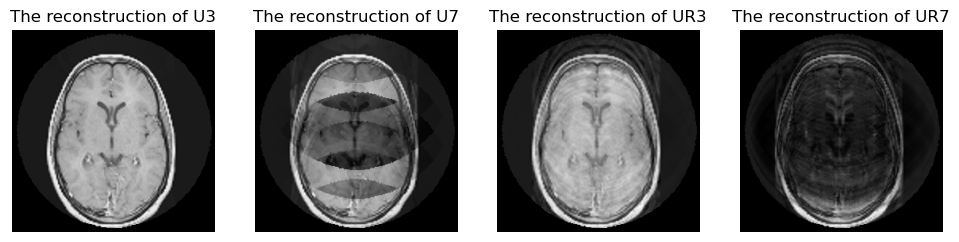

In [18]:
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(np.sqrt(np.sum(np.abs(recon_list[i])**2, axis=0)), cmap='gray')
    plt.axis('off')
    plt.title(f'The reconstruction of {pattern[i]}')

##### (e) Define the reconstruction error as the difference between the fully sampled image $m$ and your reconstructions $\hat{m}$ as: $$e=m-\hat{m}$$ and the mean square error(MSE) of the reconstruction as $$\epsilon = \frac{1}{N} \sum_{i=1}^{N}|m(i)-\hat{m}(i)|^{2}$$ where $i=1...N$ indicate each pixel in the image. 
#### For all reconstructions (i.e. uniform and random 3x and 7x) plot the MSE w.r.t the number of iterations for the Gradient descent iterative SENSE method implemented. Comment about the convergence of the method.

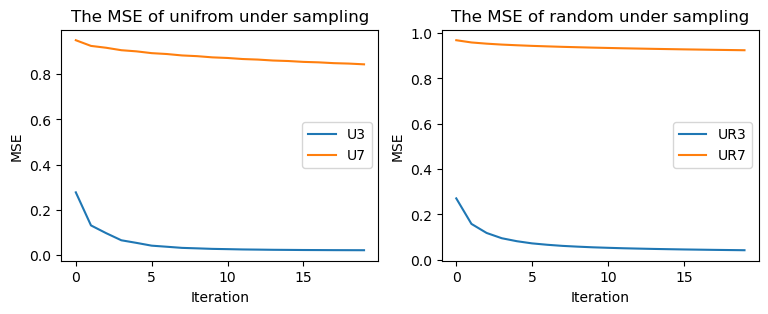

In [19]:
plt.figure(figsize=(9, 3))
plt.subplot(1,2,1)
plt.plot(u3mse, label='U3')
plt.plot(u7mse[:20], label='U7')
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title('The MSE of unifrom under sampling')
plt.legend()
plt.subplot(1,2,2)
plt.plot(ur3mse, label='UR3')
plt.plot(ur7mse[:20], label='UR7')
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title('The MSE of random under sampling')
plt.legend()